In [1]:
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,seaborn,sklearn,pywt 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
scipy 0.18.0
pandas 0.18.1
matplotlib 1.5.1
seaborn 0.7.1
sklearn 0.18
pywt 0.4.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 16.1.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import seaborn as sns

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

### Original variables
Here we uplaoad the original variables `facies_vectors.csv`

In [3]:
filename = 'data/facies_vectors.csv'
training_data_raw = pd.read_csv(filename)

# Change variable type
training_data_raw['Well Name'] = training_data_raw['Well Name'].astype('category')
training_data_raw['Formation'] = training_data_raw['Formation'].astype('category')
# Check how many wells
training_data_raw['Well Name'].unique()

training_data_raw.to_pickle('data/training_data_raw.pkl')

### Wavelet decomposition
We compute the approximation coefficients vector cA and detail coefficients vector cD, obtained by a wavelet decomposition of each logs, i.e. `GR`, `ILD_log10`, `DeltaPHI`, `PHIND`, `PE`. Next figure shows the cofficient cA and cD as well as `GR` for the `SHANKLE`well.

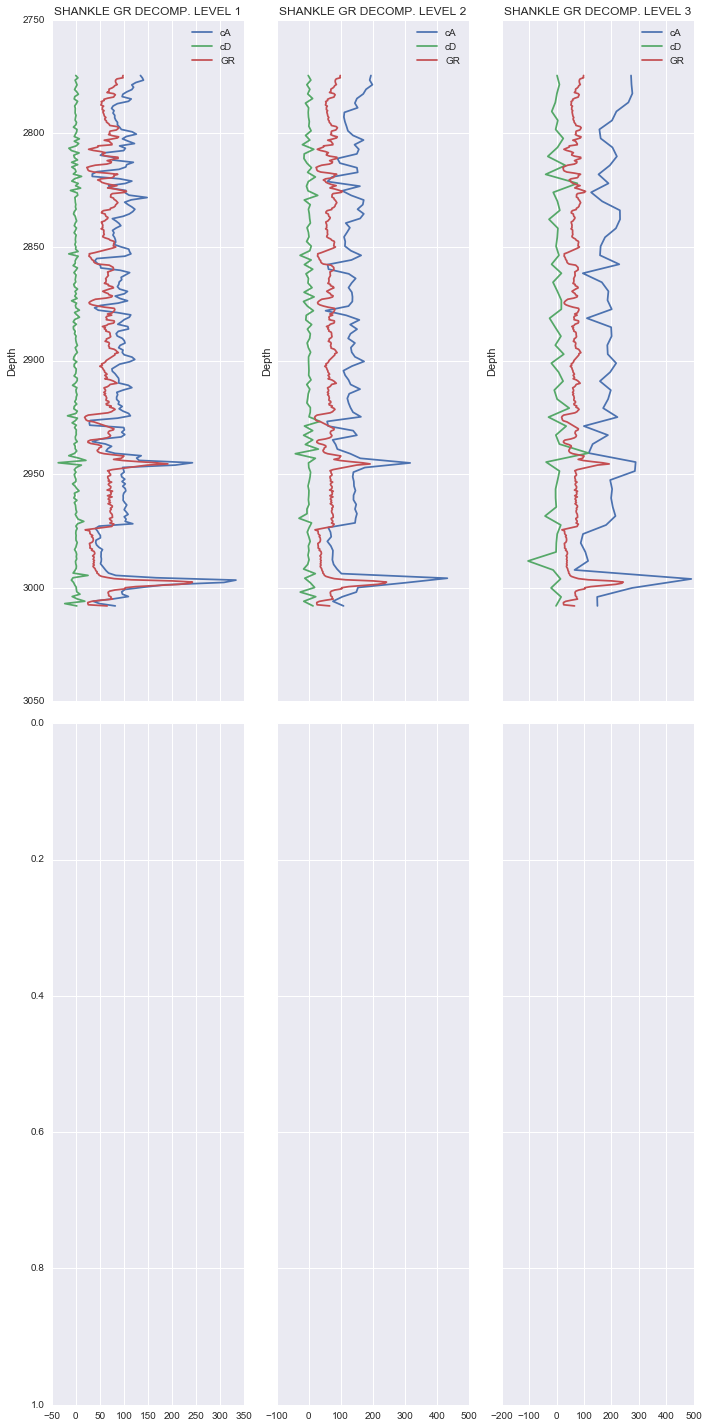

In [13]:
import pywt
from scipy.interpolate import interp1d

grouped = training_data_raw.groupby(['Well Name'])
db3 = pywt.Wavelet('db3')
data = grouped.get_group('SHANKLE').GR
depth = grouped.get_group('SHANKLE').Depth

n_levels = 3
nrows = 2
fig, axs = plt.subplots(figsize=(10,20),
                        nrows=nrows, ncols=3,
                        sharey='row',sharex='col') # Much control of gridspec
for i in range(nrows):
    axs[i,0].invert_yaxis()


temp_data = data
for i,ax in zip(range(1,n_levels+1),axs.flatten()):
    
    cA,cD = pywt.dwt(temp_data,db3,mode='symmetric')
    ax.plot(cA,np.linspace(min(depth),max(depth),len(cA)))
    ax.plot(cD,np.linspace(min(depth),max(depth),len(cD)))
    ax.plot(data,depth)
    ax.set_title('SHANKLE GR DECOMP. LEVEL %d' % (i))
    ax.set_ylabel('Depth')
    ax.legend(['cA','cD','GR'])
    plt.tight_layout()
    temp_data = cA

In [14]:
n_levels = 3
new_vars = pd.DataFrame()

for key in grouped.groups.keys():
    
    depth = grouped.get_group(key)['Depth']
    temp_df = pd.DataFrame()
    temp_df['Depth'] = depth
    for log in ['GR','ILD_log10','DeltaPHI','PHIND','PE']:
      
        temp_data = grouped.get_group(key)[log]
        
        for i in range(1,n_levels+1):

            cA,cD = pywt.dwt(temp_data,db3,mode='symmetric')

            new_depth = np.linspace(min(depth),max(depth),len(cD))
#             f1 = interp1d(new_depth,cD,kind='linear')
            f2 = interp1d(new_depth,cD,kind='nearest')
#             f3 = interp1d(new_depth,cA,kind='linear')

#             temp_df[log + '_cD_lin_level_' + str(i)] = f1(depth)
            temp_df[log + '_cD_step_level_' + str(i)] = f2(depth)
#             temp_df[log + '_cA_level_' + str(i)] = f3(depth)
    
    temp_df['Well Name'] = [key for _ in range(len(depth))]
    new_vars = new_vars.append(temp_df)

new_vars = new_vars.sort_index()
new_vars.to_pickle('data/vars_from_dwt.pkl')

### Entropy calculation
Entropy 

In [15]:
del new_vars
from skimage.filters.rank import entropy
from skimage.morphology import rectangle
from skimage.util import img_as_ubyte

new_vars = pd.DataFrame()
l_foot = 10
footprint = rectangle(l_foot,3)

for key in grouped.groups.keys():
    
    depth = grouped.get_group(key)['Depth']
    temp_df = pd.DataFrame()
    temp_df['Depth'] = depth
    for log in ['GR','ILD_log10','DeltaPHI','PHIND','PE']:
      
        temp_data = grouped.get_group(key)[log]
        
        image = np.vstack((temp_data,temp_data,temp_data))
        image -= np.median(image) 
        image /= np.max(np.abs(image))
        image = img_as_ubyte(image)
        
        temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
    temp_df['Well Name'] = [key for _ in range(len(depth))]
    new_vars = new_vars.append(temp_df)
    
new_vars = new_vars.sort_index()
new_vars.to_pickle('data/vars_from_log_entropy.pkl')

/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [16]:
raw_logs = pd.read_pickle('data/training_data_raw.pkl')
raw_logs.replace(to_replace=np.nan, value=-99999.0, inplace=True)

dwt = pd.read_pickle('data/vars_from_dwt.pkl')
dwt.replace(to_replace=np.nan, value=-99999.0, inplace=True)

entropy = pd.read_pickle('data/vars_from_log_entropy.pkl')
entropy.replace(to_replace=np.nan, value=-99999.0, inplace=True)

training_data = pd.merge(raw_logs,dwt,on=['Depth','Well Name'])
training_data = pd.merge(training_data,entropy, on=['Depth','Well Name'])

# training_data = raw_logs
training_data.head()
# training_data.isnull().sum()# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.replace(to_replace=np.nan, value=-99999.0, inplace=True)
training_data['FaciesLabels'].value_counts()

CSiS    946
FSiS    786
PS      692
WS      582
MS      296
SiSh    271
SS      268
BS      185
D       141
Name: FaciesLabels, dtype: int64

In [17]:
training_data.to_pickle('data/training_data.pkl')

In [11]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_cA_level_1,...,PE_cA_level_2,PE_cA_level_3,PE_cA_level_4,PE_cA_level_5,PE_cA_level_6,GR_entropy_foot5,ILD_log10_entropy_foot5,DeltaPHI_entropy_foot5,PHIND_entropy_foot5,PE_entropy_foot5
count,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,...,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000
mean,4.502520,2906.351092,65.248225,0.659125,4.412696,13.203811,-22003.113383,1.519078,0.523053,92.202692,...,-21929.912277,-21929.912277,-21929.912277,-21929.912277,-21929.912277,0.803668,0.778121,0.869436,0.831015,0.546265
std,2.475018,133.443259,30.951925,0.252315,5.267093,7.119856,41434.948570,0.499696,0.287208,41.765442,...,41386.841921,41386.841921,41386.841921,41386.841921,41386.841921,0.727580,0.740063,0.719423,0.738078,0.684827
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,-99999.000000,1.000000,0.000000,16.215743,...,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2820.750000,44.912000,0.497034,1.602000,8.512250,2.442500,1.000000,0.278000,64.341188,...,3.576509,3.576509,3.576509,3.576509,3.576509,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2932.500000,65.125000,0.639000,4.300000,12.036000,3.300000,2.000000,0.528000,92.106729,...,4.659511,4.659511,4.659511,4.659511,4.659511,0.918296,0.918296,0.918296,0.918296,0.000000
75%,6.000000,3006.500000,79.535000,0.821000,7.500000,16.057000,4.000000,2.000000,0.769000,111.983461,...,5.713660,5.713660,5.713660,5.713660,5.713660,1.584963,1.584963,1.584963,1.584963,1.584963
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,465.212606,...,10.671954,10.671954,10.671954,10.671954,10.671954,1.584963,1.584963,1.584963,1.584963,1.584963
